In [1]:
import sv_utils
import torch 
import numpy as np
import pylab as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
from os.path import dirname, realpath
from singleNeuron import preSpikes, nextSpikes, STDPLIFDensePopulation, convergence_level, get_metrics, get_metrics_long_pat

## Sequence Visualizer

El proposito de esta notebook es el poder graficar tanto la entrada como salida de la red DSNN que reconoce patrones en una secuencia de numeros aleatorios.

In [2]:
Sin_tmp = np.load('./sequences/p_18/testing/15_0_0/layer_5_conv.pt')
print(Sin_tmp.shape)
Sin = np.reshape(Sin_tmp, (Sin_tmp.shape[0]*Sin_tmp.shape[1], Sin_tmp.shape[2]))
Sin = np.transpose(Sin)
print(Sin.shape)

NameError: name 'np' is not defined

### Tren de spikes de entrada

In [2]:
plt.rcParams["figure.figsize"] =(15,6)
#sv_utils.plotLIF(U=None, S=Sin[:200])
#print("Spikes: " + str(np.count_nonzero(Sin)))

### Tren de spikes de salida 

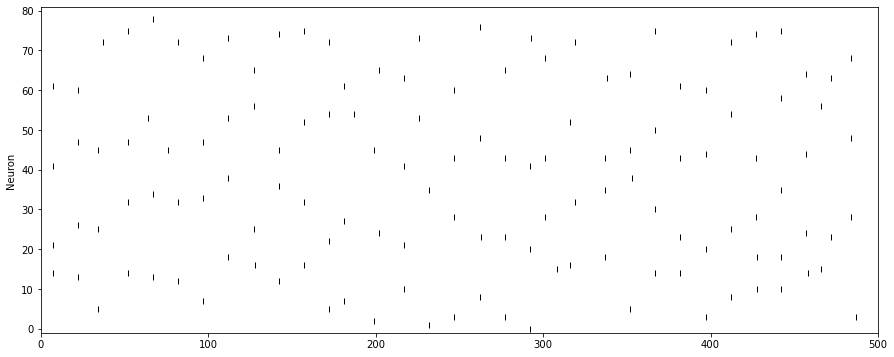

torch.Size([89970, 80])
Spikes: 24049


In [3]:
Sin_out_s = torch.load('../cleanDSNN/results/old_results/p_18/limited_spikes/training/15_0_0/layer_5_conv.pt')
sv_utils.plotLIF(U=None, S=Sin_out_s[:500].data.numpy())
print(Sin_out_s.shape)
print("Spikes: " + str(np.count_nonzero(Sin_out_s)))

## Entrenamos a la neurona de salida

In [20]:
#pat_times = np.load('./sequences/p_18/training/pat_p_18.npy')
Sin = Sin_out_s.clone().detach()
T = Sin.shape[0]
N_out = 1
N_in = Sin.shape[1]
th = 3.

singleNeuron = STDPLIFDensePopulation(in_channels=N_in, out_channels=N_out,
                                        weight=0.70, alpha=float(np.exp(-1e-3/10e-3)),
                                        beta=float(np.exp(-1e-3/2e-5)), delay=0,
                                        th=th, a_plus=.009125, a_minus=.0125625,
                                        w_max=1.)


# Pre-procesamos PSpikes y NSpikes
dt_ltp = 20  # Cantidad de timesteps que miro hacia atras
dt_ltd = 70  # Cantidad de timesteps que miro hacia delante
PSpikes = preSpikes(T, dt_ltp, torch.zeros(T, N_in), Sin)
NSpikes = nextSpikes(T, dt_ltd, torch.zeros(T, N_in), Sin)

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])

n = 0
t = 0
c_l = 1.
while (c_l > 0.01) and (t < 300000):
    state = singleNeuron.forward(Sin[n].unsqueeze(0), PSpikes[n], NSpikes[n-1])
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    n += 1
    if n >= T:
        n = 0
    c_l = convergence_level(singleNeuron.fc_layer.weight[0])
    t += 1
    if (t % 500) == 0:
        print("iter: " + str(t) + " convergence: " + str(c_l))


iter: 500 convergence: 0.21134839086423804
iter: 1000 convergence: 0.2125691588754072
iter: 1500 convergence: 0.21342297005117863
iter: 2000 convergence: 0.21436025450117818
iter: 2500 convergence: 0.2156560912753128
iter: 3000 convergence: 0.21673254802081998
iter: 3500 convergence: 0.2178825087161051
iter: 4000 convergence: 0.21876159530883932
iter: 4500 convergence: 0.21959824042011328
iter: 5000 convergence: 0.2204071027397058
iter: 5500 convergence: 0.2212630248732324
iter: 6000 convergence: 0.22192694030114843
iter: 6500 convergence: 0.22283270202728084
iter: 7000 convergence: 0.2234000069544289
iter: 7500 convergence: 0.22360551588723115
iter: 8000 convergence: 0.2241426225096445
iter: 8500 convergence: 0.22476234937395995
iter: 9000 convergence: 0.22498802540594878
iter: 9500 convergence: 0.22513321026031155
iter: 10000 convergence: 0.2252369280193367
iter: 10500 convergence: 0.2255639046012941
iter: 11000 convergence: 0.22557702800473517
iter: 11500 convergence: 0.225871630053

iter: 92500 convergence: 0.10730714401213974
iter: 93000 convergence: 0.10708713969889283
iter: 93500 convergence: 0.10687795564785763
iter: 94000 convergence: 0.10637081450635048
iter: 94500 convergence: 0.10619226426447556
iter: 95000 convergence: 0.1052175348050779
iter: 95500 convergence: 0.10570230554003335
iter: 96000 convergence: 0.10551820882201453
iter: 96500 convergence: 0.10439394598849865
iter: 97000 convergence: 0.10402015089738029
iter: 97500 convergence: 0.10360174822995591
iter: 98000 convergence: 0.10303884213128187
iter: 98500 convergence: 0.10208565006271417
iter: 99000 convergence: 0.10249984094202498
iter: 99500 convergence: 0.10216535447362937
iter: 100000 convergence: 0.10131980260716192
iter: 100500 convergence: 0.10141547405322253
iter: 101000 convergence: 0.10068876527880137
iter: 101500 convergence: 0.10085711167539439
iter: 102000 convergence: 0.09965634073307642
iter: 102500 convergence: 0.09967280216907727
iter: 103000 convergence: 0.09952643544120622
iter

iter: 182500 convergence: 0.06051832554012513
iter: 183000 convergence: 0.059993525022595695
iter: 183500 convergence: 0.05956724504058543
iter: 184000 convergence: 0.059264048207440814
iter: 184500 convergence: 0.059375709170496394
iter: 185000 convergence: 0.05868854210164613
iter: 185500 convergence: 0.05956149931980668
iter: 186000 convergence: 0.05968851625246746
iter: 186500 convergence: 0.05945280953358752
iter: 187000 convergence: 0.05886341218233114
iter: 187500 convergence: 0.058442658968254645
iter: 188000 convergence: 0.05827353247602415
iter: 188500 convergence: 0.05793676611635916
iter: 189000 convergence: 0.05822313569081551
iter: 189500 convergence: 0.05734848845917345
iter: 190000 convergence: 0.056591434498814576
iter: 190500 convergence: 0.0572752251825487
iter: 191000 convergence: 0.057424595501273455
iter: 191500 convergence: 0.05748055972392713
iter: 192000 convergence: 0.05700783753597697
iter: 192500 convergence: 0.057059105047495395
iter: 193000 convergence: 0.

iter: 272000 convergence: 0.04010064261684125
iter: 272500 convergence: 0.03998924679557513
iter: 273000 convergence: 0.03991696351774953
iter: 273500 convergence: 0.03948428846759322
iter: 274000 convergence: 0.03909739267599696
iter: 274500 convergence: 0.03917939746651231
iter: 275000 convergence: 0.03870369881080011
iter: 275500 convergence: 0.03939242651791351
iter: 276000 convergence: 0.03957939081126243
iter: 276500 convergence: 0.039174926640496766
iter: 277000 convergence: 0.03873770092450461
iter: 277500 convergence: 0.0382182687284573
iter: 278000 convergence: 0.03814509382296431
iter: 278500 convergence: 0.03799094388118323
iter: 279000 convergence: 0.03812567732258092
iter: 279500 convergence: 0.037457019331799665
iter: 280000 convergence: 0.03656786055491455
iter: 280500 convergence: 0.03700999112613261
iter: 281000 convergence: 0.03774916587039707
iter: 281500 convergence: 0.037885168257957944
iter: 282000 convergence: 0.037645264316693364
iter: 282500 convergence: 0.037

## Graficamos la salida para la secuencia de testing y mostramos metricas

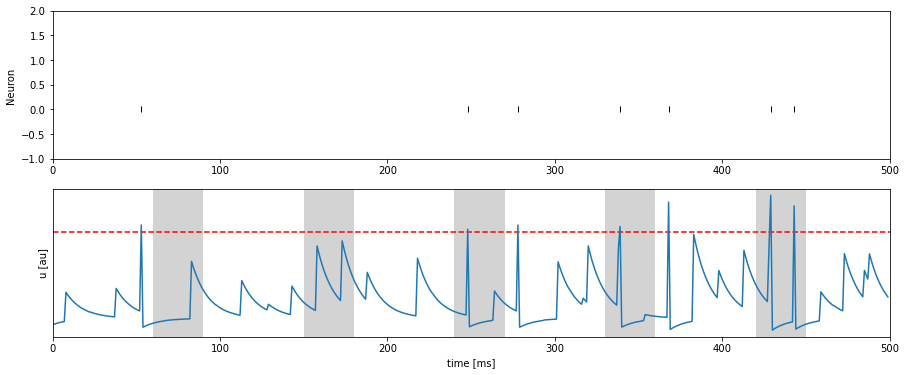

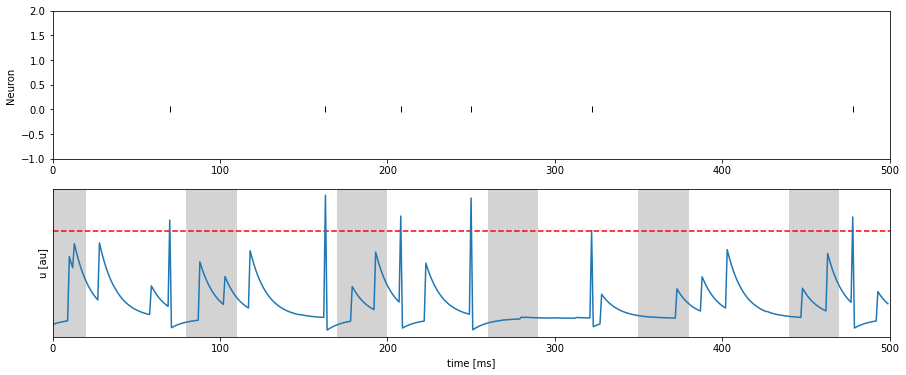

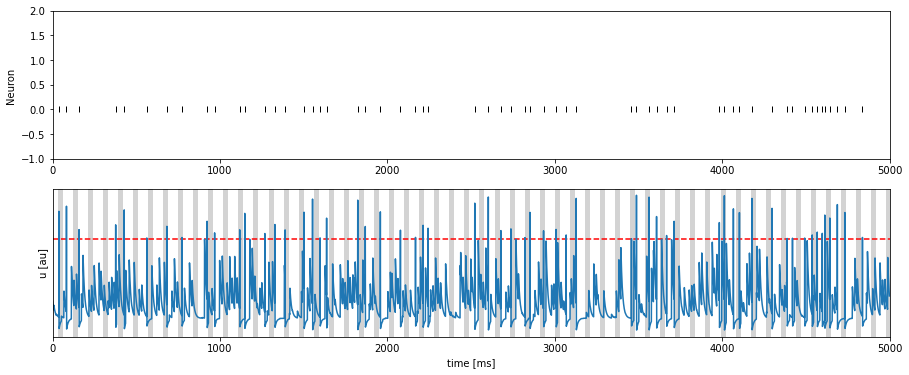

accuracy: 0.6136401534100383
precision: 0.3357363542739444
recall: 0.16316316316316315
f1: 0.2196025597844392
fake_alarms: 0.16129032258064516
missed_alarms: 0.8368368368368369


In [21]:
pat_times = np.load('./sequences/p_18/training/pat_p_18.npy')
Sin_tmp = torch.load('../cleanDSNN/results/old_results/p_18/limited_spikes/15_0_0/training/layer_5_conv.pt')
T = Sin_tmp.shape[0]
N_out = 1
N_in = Sin_tmp.shape[1]
th = 3.

Sin = Sin_tmp.clone().detach()

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])
for n in range(T):
    state = singleNeuron.forward_no_learning(Sin[n].unsqueeze(0))
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    
sv_utils.plotLIF(U=Uprobe[0:500], S=Sprobe[0:500], pat_times=pat_times[0:500], th=th)
sv_utils.plotLIF(U=Uprobe[2500:3000], S=Sprobe[2500:3000], pat_times=pat_times[2500:3000], th=th)
sv_utils.plotLIF(U=Uprobe[30000:35000], S=Sprobe[30000:35000], pat_times=pat_times[30000:35000], th=th)


accuracy, precision, recall, f1, fake_alarms, missed_alarms = get_metrics(T - 15, pat_times, Sprobe)
print("accuracy: " + str(accuracy))
print("precision: " + str(precision))
print("recall: " + str(recall))
print("f1: " + str(f1))
print("fake_alarms: " + str(fake_alarms))
print("missed_alarms: " + str(missed_alarms))

# Parallel Architecture

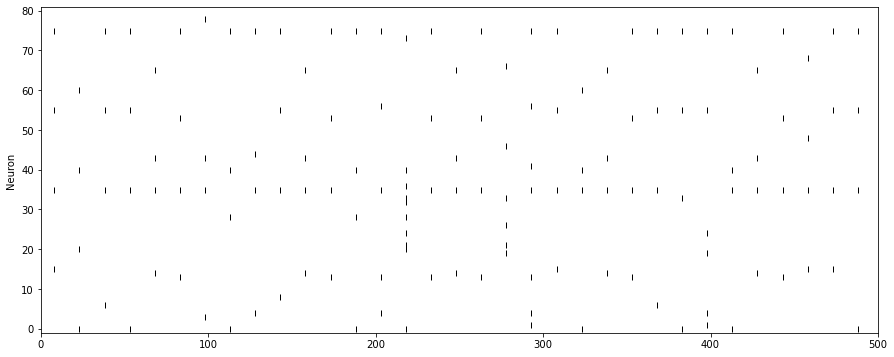

torch.Size([89970, 80])
Sequential Spikes: 25794


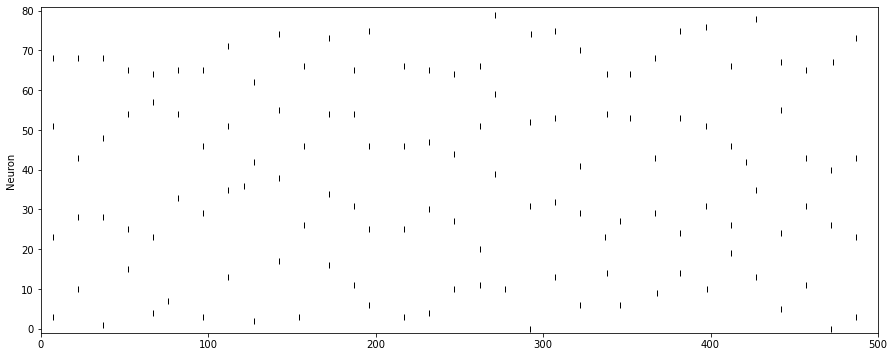

torch.Size([89970, 80])
Parallel Spikes: 23914


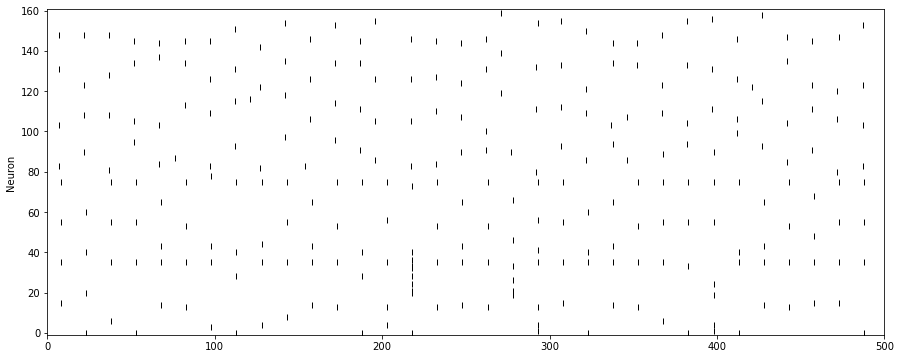

torch.Size([89970, 160])
Combined Spikes: 49708


In [7]:
Sin_out_seq = torch.load('../cleanDSNN/results/old_results/massive_runs/18/0_0_0/p_18/training/0/layer_5_conv.pt')
sv_utils.plotLIF(U=None, S=Sin_out_seq[:500].data.numpy())
print(Sin_out_seq.shape)
print("Sequential Spikes: " + str(np.count_nonzero(Sin_out_seq)))

Sin_out_par = torch.load('../cleanDSNN/results/old_results/massive_runs/18/15_0_0/p_18/training/0/layer_5_conv.pt')
sv_utils.plotLIF(U=None, S=Sin_out_par[:500].data.numpy())
print(Sin_out_par.shape)
print("Parallel Spikes: " + str(np.count_nonzero(Sin_out_par)))

combined_out = torch.cat((Sin_out_seq, Sin_out_par), 1)
sv_utils.plotLIF(U=None, S=combined_out[:500].data.numpy())
print(combined_out.shape)
print("Combined Spikes: " + str(np.count_nonzero(combined_out)))

# Realizamos el entrenamiento

In [8]:
Sin = combined_out.clone().detach()
T = Sin.shape[0]
N_out = 1
N_in = Sin.shape[1]
th = 4.

singleNeuron = STDPLIFDensePopulation(in_channels=N_in, out_channels=N_out,
                                        weight=0.70, alpha=float(np.exp(-1e-3/10e-3)),
                                        beta=float(np.exp(-1e-3/2e-5)), delay=0,
                                        th=th, a_plus=.009125, a_minus=.0125625,
                                        w_max=1.)


# Pre-procesamos PSpikes y NSpikes
dt_ltp = 20  # Cantidad de timesteps que miro hacia atras
dt_ltd = 70  # Cantidad de timesteps que miro hacia delante
PSpikes = preSpikes(T, dt_ltp, torch.zeros(T, N_in), Sin)
NSpikes = nextSpikes(T, dt_ltd, torch.zeros(T, N_in), Sin)

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])

n = 0
t = 0
c_l = 1.
while (c_l > 0.01) and (t < 300000):
    state = singleNeuron.forward(Sin[n].unsqueeze(0), PSpikes[n], NSpikes[n-1])
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    n += 1
    if n >= T:
        n = 0
    c_l = convergence_level(singleNeuron.fc_layer.weight[0])
    t += 1
    if (t % 500) == 0:
        print("iter: " + str(t) + " convergence: " + str(c_l))

iter: 500 convergence: 0.21074298005959421
iter: 1000 convergence: 0.2123019979648789
iter: 1500 convergence: 0.21475716338423662
iter: 2000 convergence: 0.21648161845470265
iter: 2500 convergence: 0.21821598770958683
iter: 3000 convergence: 0.22000093633663864
iter: 3500 convergence: 0.22181764848081773
iter: 4000 convergence: 0.2227742497297167
iter: 4500 convergence: 0.22342506126095224
iter: 5000 convergence: 0.22375848396908263
iter: 5500 convergence: 0.22322840244360984
iter: 6000 convergence: 0.22315553911462188
iter: 6500 convergence: 0.22255877394651308
iter: 7000 convergence: 0.22162514827728907
iter: 7500 convergence: 0.22217756072694578
iter: 8000 convergence: 0.2217482067517241
iter: 8500 convergence: 0.2221017310989856
iter: 9000 convergence: 0.22237026173448218
iter: 9500 convergence: 0.22243926586350682
iter: 10000 convergence: 0.22233617308421544
iter: 10500 convergence: 0.22238591870033572
iter: 11000 convergence: 0.22243109081555476
iter: 11500 convergence: 0.2221298

iter: 92500 convergence: 0.10794037182124727
iter: 93000 convergence: 0.10745875058658498
iter: 93500 convergence: 0.10756388370103058
iter: 94000 convergence: 0.10737888182931321
iter: 94500 convergence: 0.1071484214428644
iter: 95000 convergence: 0.10721015874337599
iter: 95500 convergence: 0.10703400950213549
iter: 96000 convergence: 0.10704046452498325
iter: 96500 convergence: 0.10713073782229592
iter: 97000 convergence: 0.10671330604135428
iter: 97500 convergence: 0.10688533854215825
iter: 98000 convergence: 0.1066481279197498
iter: 98500 convergence: 0.10637578013352647
iter: 99000 convergence: 0.1062228078867068
iter: 99500 convergence: 0.10595332924926085
iter: 100000 convergence: 0.10539269244014873
iter: 100500 convergence: 0.1055714034731274
iter: 101000 convergence: 0.10560204294281517
iter: 101500 convergence: 0.1051563087463987
iter: 102000 convergence: 0.10502406024745388
iter: 102500 convergence: 0.10465688246471487
iter: 103000 convergence: 0.10422968386306279
iter: 10

iter: 182000 convergence: 0.0825188936309936
iter: 182500 convergence: 0.08221962040693957
iter: 183000 convergence: 0.0817893281561336
iter: 183500 convergence: 0.08165245999473433
iter: 184000 convergence: 0.08196249400741885
iter: 184500 convergence: 0.08169471830647114
iter: 185000 convergence: 0.08155988359850411
iter: 185500 convergence: 0.08179634054896165
iter: 186000 convergence: 0.08172610299868013
iter: 186500 convergence: 0.08136820950257012
iter: 187000 convergence: 0.0813124048303327
iter: 187500 convergence: 0.08111041558002421
iter: 188000 convergence: 0.08124216733897374
iter: 188500 convergence: 0.08151881137408565
iter: 189000 convergence: 0.08134163336192554
iter: 189500 convergence: 0.08139510789412864
iter: 190000 convergence: 0.08171643195806118
iter: 190500 convergence: 0.08169191591575589
iter: 191000 convergence: 0.08182682252176961
iter: 191500 convergence: 0.081419927324297
iter: 192000 convergence: 0.08099376084011842
iter: 192500 convergence: 0.08082735116

iter: 271500 convergence: 0.07233837346174037
iter: 272000 convergence: 0.07188426096158222
iter: 272500 convergence: 0.07157363610143719
iter: 273000 convergence: 0.0713617513269465
iter: 273500 convergence: 0.0716061240079046
iter: 274000 convergence: 0.07177980894692443
iter: 274500 convergence: 0.07154270633677366
iter: 275000 convergence: 0.07155307477649683
iter: 275500 convergence: 0.07184940437322387
iter: 276000 convergence: 0.07178168009288288
iter: 276500 convergence: 0.07140965905626032
iter: 277000 convergence: 0.0713058934247058
iter: 277500 convergence: 0.07113085604012802
iter: 278000 convergence: 0.07118000720529918
iter: 278500 convergence: 0.07148646197864882
iter: 279000 convergence: 0.07149374840732765
iter: 279500 convergence: 0.07141946354961029
iter: 280000 convergence: 0.07182734133091426
iter: 280500 convergence: 0.07175790239252772
iter: 281000 convergence: 0.07197530326170494
iter: 281500 convergence: 0.07146012374235691
iter: 282000 convergence: 0.071187735

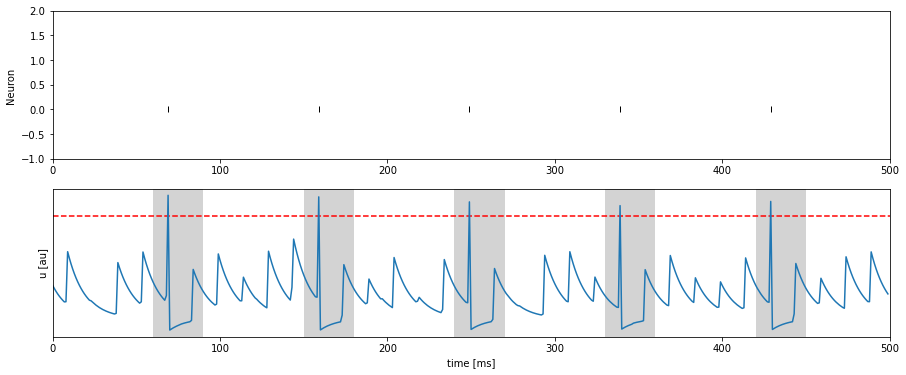

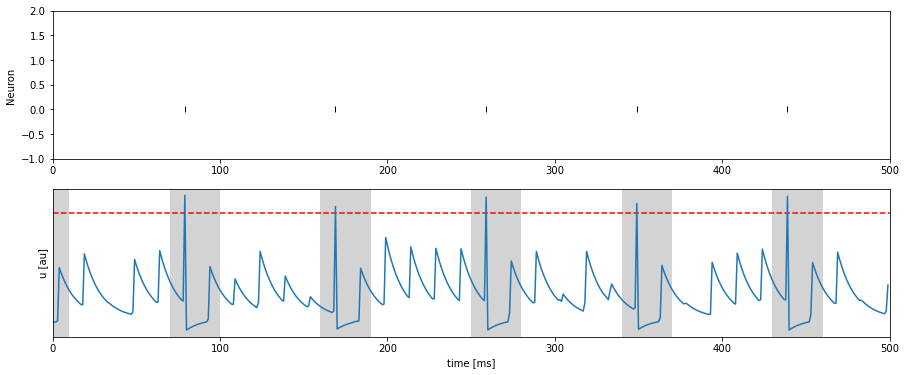

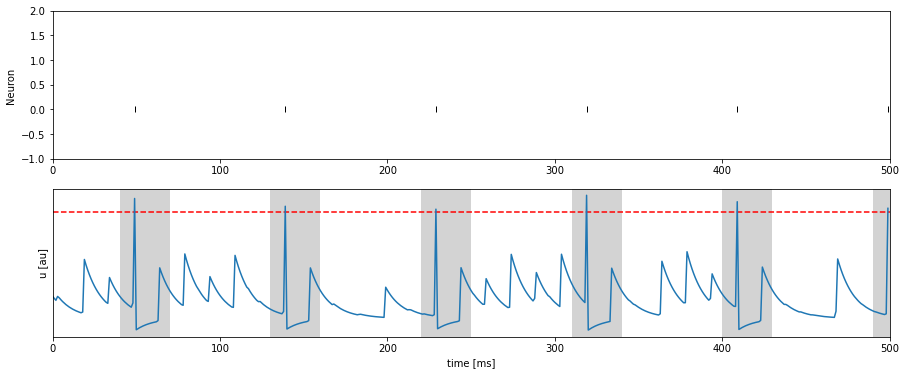

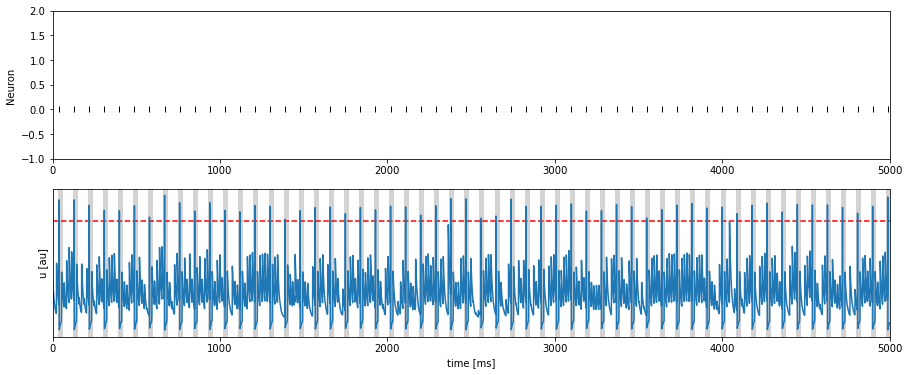

accuracy: 0.9981992797118847
precision: 0.9930278884462151
recall: 0.997997997997998
f1: 0.9955067398901648
fake_alarms: 0.0017504376094023505
missed_alarms: 0.002002002002002002
fake_spikes_numbers: [(18, 25, 0, 47), (10, 26, 0, 182), (14, 19, 0, 196), (14, 21, 1, 324), (12, 22, 1, 375), (22, 14, 0, 478), (16, 21, 0, 515)]


In [9]:
pat_times = np.load('./sequences/massive_runs/18/p_18/training/0/pat_p_18.npy')
pat_number = np.load('./sequences/massive_runs/18/p_18/training/0/data_p_18.npy')
Sin_tmp_seq = torch.load('../cleanDSNN/results/old_results/massive_runs/18/0_0_0/p_18/training/0/layer_5_conv.pt')
Sin_tmp_par = torch.load('../cleanDSNN/results/old_results/massive_runs/18/15_0_0/p_18/training/0/layer_5_conv.pt')

Sin_tmp = torch.cat((Sin_tmp_seq, Sin_tmp_par), 1)
T = Sin_tmp.shape[0]
N_out = 1
N_in = Sin_tmp.shape[1]
th = 4.

Sin = Sin_tmp.clone().detach()

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])
for n in range(T):
    state = singleNeuron.forward_no_learning(Sin[n].unsqueeze(0))
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    

sv_utils.plotLIF(U=Uprobe[0:500], S=Sprobe[0:500], pat_times=pat_times[0:500], th=th)
sv_utils.plotLIF(U=Uprobe[8000:8500], S=Sprobe[8000:8500], pat_times=pat_times[8000:8500], th=th)
sv_utils.plotLIF(U=Uprobe[20000:20500], S=Sprobe[20000:20500], pat_times=pat_times[20000:20500], th=th)
sv_utils.plotLIF(U=Uprobe[30000:35000], S=Sprobe[30000:35000], pat_times=pat_times[30000:35000], th=th)


accuracy, precision, recall, f1, fake_alarms, missed_alarms, fake_spikes_numbers = get_metrics_long_pat(T - 15, pat_times, Sprobe, 30, pat_number)
print("accuracy: " + str(accuracy))
print("precision: " + str(precision))
print("recall: " + str(recall))
print("f1: " + str(f1))
print("fake_alarms: " + str(fake_alarms))
print("missed_alarms: " + str(missed_alarms))
print("fake_spikes_numbers: " + str(fake_spikes_numbers))